In [58]:
# GCAME with variable input images
# Source: https://github.com/khanhnguyenuet/GCAME

In [59]:
# Note from authors
'''
To make it easier in applying GCAME, we make some changes in post-processing phase of the model.
Go to file ./YOLOX/yolox/utils/boxes.py and change function postprocess as follow:

def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]
    idx = None
    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        idx = (conf_mask == True).nonzero(as_tuple=True)[0]
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        idx = idx[nms_out_index]
        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output, idx
    
(This function will return the output bounding box with the index of each box after running NMS algorithm)
'''

'\nTo make it easier in applying GCAME, we make some changes in post-processing phase of the model.\nGo to file ./YOLOX/yolox/utils/boxes.py and change function postprocess as follow:\n\ndef postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):\n    box_corner = prediction.new(prediction.shape)\n    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2\n    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2\n    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2\n    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2\n    prediction[:, :, :4] = box_corner[:, :, :4]\n    idx = None\n    output = [None for _ in range(len(prediction))]\n    for i, image_pred in enumerate(prediction):\n\n        # If none are remaining => process next image\n        if not image_pred.size(0):\n            continue\n        # Get score and class with highest confidence\n        class_conf, class_pred = torch

In [60]:
# Clone model YOLOX from github (Run 1 first time only)
# !git clone https://github.com/Megvii-BaseDetection/YOLOX.git

In [61]:
# Install yolox (In terminal; Run 1 first time only)
# Source: https://yolox.readthedocs.io/en/latest/quick_run.html
# pip3 install -U pip && pip3 install -r requirements.txt
# pip3 install -v -e .  # or  python3 setup.py develop

In [62]:
# Install all packages (Run 1 first time only)
# %pip install -r ./YOLOX/requirements.txt # change from !pip to %pip
# %pip install kornia # change from !pip to %pip

In [63]:
# Load the label of COCO dataset
coco = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']

In [64]:
import sys
sys.path.append('/content/YOLOX')

In [65]:
# Import packages
from yolox import models
from yolox.utils import *
from yolox.data import data_augment

import torch
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
from torch.nn import functional as F
import torch.nn as nn

import os
from tqdm import tqdm
import copy
import timeit

In [66]:
# Clear CUDA cache
# Source: https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
torch.cuda.empty_cache()

In [67]:
# Get pretrained model and its transform function
# (In our paper, we use YOLOX-l to do experiment)
model = models.yolox_l(pretrained=True)
transform = data_augment.ValTransform(legacy=False)

In [68]:
# Name of all layers in YOLOX-l
# for n, p in model.named_modules():
  # print(n)

In [69]:
from math import floor
import math

# This function to create Gaussian mask used in algorithm
def create_heatmap(output_width, output_height, p_x, p_y, sigma):
    """
    Parameters: 
      - output_width, output_height: The kernel size of Gaussian mask
      - p_x, p_y: The center of Gaussian mask
      - sigma: The standard deviation of Gaussian mask
    Returns:
      - mask: The 2D-array Gaussian mask in range [0, 1]
    """
    X1 = np.linspace(1, output_width, output_width)
    Y1 = np.linspace(1, output_height, output_height)
    [X, Y] = np.meshgrid(X1, Y1)
    X = X - floor(p_x)
    Y = Y - floor(p_y)
    D2 = X * X + Y * Y
    E2 = 2.0 * sigma ** 2
    Exponent = D2 / E2
    mask = np.exp(-Exponent)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask

class GCAME(object):
    def __init__(self, model, target_layers, img_size=(640, 640), **kwargs):
        """
        Parameters:
          - model: The model in nn.Module() to analyze
          - target_layers: List of names of the target layers in model.named_modules()
          - img_size: The size of image in tuple
        Variables:
          - self.gradients, self.activations: Dictionary to save the value when
            do forward/backward in format {'name_layer': activation_map/gradient}
          - self.handlers: List of hook functions
        """
        self.model = model.eval()
        self.img_size = img_size
        self.gradients = dict()           
        self.activations = dict()
        self.target_layers = target_layers
        self.handlers = []

        # Save gradient values and activation maps
        def save_grads(key):    
            def backward_hook(module, grad_inp, grad_out):
                g = grad_out[0].detach()
                self.gradients[key] = g
            return backward_hook

        def save_fmaps(key):
            def forward_hook(module, inp, output):
                self.activations[key] = output.detach() 
            return forward_hook
        
        for name, module in self.model.named_modules():        
            if name in self.target_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def __call__(self, img, box, obj_idx=None):
        return self.forward(img, box, obj_idx)

    def forward(self, img, box, obj_idx=None):
      """
      Parameters:
        - img: Input image in Tensor[1, 3, H, W]
        - box: The bounding box to analyze Tensor([xmin, ymin, xmax, ymax, p_obj, p_cls, cls])
        - obj_index: The index of target bounding box in int
      Returns:
        - score_saliency_map: The saliency map of target object
      """
  
      eps = 1e-7
      b, c, h, w = img.shape
      self.model.zero_grad()
      # Get the prediction of the model and the index of each predicted bouding box
      pred = self.model(img)
      _, index = postprocess(pred, 80, 0.25, 0.45, True)

      # num_objs = box.shape[0]
      # target_box = box[:4]
      # target_score = box[4] * box[5]
      # pred_all_score = pred[0][index[obj_idx]][5:]

      target_cls = box[6].int()
      self.model.zero_grad()
      # Do backward
      pred[0][index[obj_idx]][target_cls + 5].backward(retain_graph=True)
      
      # Create the saliency map
      score_saliency_map = np.zeros((self.img_size[0], self.img_size[1]))

      for key in self.activations.keys():
        map = self.activations[key]
        grad = self.gradients[key]

        # Select the branch that the target comes out
        if grad.max().item() == 0 and grad.min().item() == 0:
          continue
        
        map = map.squeeze().cpu().numpy()
        grad = grad.squeeze().cpu().numpy()

        # Calculate the proportion between the input image and the gradient map
        stride = self.img_size[0] / grad.shape[1]
        for j in tqdm(range(map.shape[0])):
          weighted_map = map[j]
          mean_grad = np.mean(grad[j])

          # Get the center of the Gaussian mask
          id_x, id_y = (grad[j] != 0).nonzero()
          if len(id_x) == 0 or len(id_y) == 0:
            continue
          
          id_x = id_x[0]
          id_y = id_y[0]

          # Weight the feature map
          weighted_map = abs(mean_grad) * map[j]
          kn_size = math.floor(math.sqrt(grad.shape[1] * grad.shape[2]) - 1) / 2 / 3
          sigma = (np.log(abs(mean_grad)) / kn_size) * np.log(stride)
          mask = create_heatmap(grad[j].shape[1], grad[j].shape[0], id_y, id_x, abs(sigma))
          weighted_map *= mask
          weighted_map = cv2.resize(weighted_map, (self.img_size[1], self.img_size[0]))
          # weighted_map[weighted_map < 0.] = 0.
          if mean_grad > 0:
            score_saliency_map += weighted_map
          else:
            score_saliency_map -= weighted_map

      score_saliency_map[score_saliency_map < 0.] = 0
      score_saliency_map = (score_saliency_map - score_saliency_map.min()) / (score_saliency_map.max() - score_saliency_map.min() + eps)

      return score_saliency_map

In [70]:
# Get a test image (Run 1 first time only; No need when there are test images in folder)
# !wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/giraffe.jpg

In [71]:
# Read and transform image
org_img = cv2.imread('./giraffe1.jpg')
# org_img = cv2.imread('./giraffe3.png')
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
h, w, c = org_img.shape
ratio = min(640 / h, 640 / w)
img, _ = transform(org_img, None, (640, 640))
img = torch.from_numpy(img).unsqueeze(0)
img = img.float()

In [72]:
img.requires_grad = False
device = 'cuda' # change from cpu to cuda, source: https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
model.eval()
# Get prediction
with torch.no_grad():
  out = model(img.to(device))  
  box, index = postprocess(out, num_classes=80, conf_thre=0.25, nms_thre=0.45, class_agnostic=True)

In [73]:
import matplotlib.colors as mcolors
overlap = {name for name in mcolors.CSS4_COLORS
           if f'xkcd:{name}' in mcolors.XKCD_COLORS}
all_colors = []
for color_name in overlap:
  css4 = mcolors.CSS4_COLORS[color_name]
  all_colors.append(css4)
  xkcd = mcolors.XKCD_COLORS[f'xkcd:{color_name}'].upper()
  all_colors.append(xkcd)

2


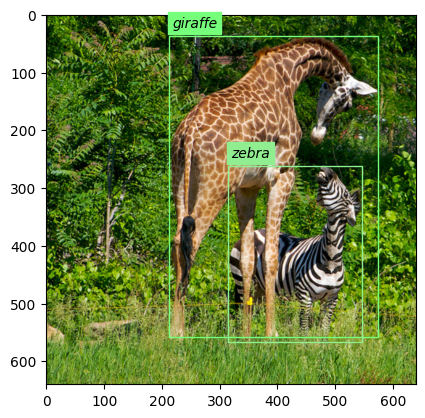

In [74]:
# Show prediction
pred = box[0].cpu().detach().numpy()
fig, ax = plt.subplots()
for i, b in enumerate(pred):
  x1, y1, x2, y2 = b[:4]
  area = (x2 - x1) * (y2 - y1) 
  p_obj = b[4] * b[5]
  cls = int(b[6])
  ax.text(x1+5, y1-16, coco[cls], style='italic', bbox={
        'facecolor': all_colors[cls], 'boxstyle': 'square', 'edgecolor': all_colors[cls]})
  rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
  ax.add_patch(rect)
ax.imshow(img.squeeze().numpy().transpose(1, 2, 0).astype(np.uint8))
print(len(pred))

In [75]:
box[0]

tensor([[212.7469,  37.0121, 574.3322, 557.4442,   0.9972,   0.9574,  23.0000],
        [314.7921, 262.0747, 546.0039, 566.5285,   0.9956,   0.9343,  22.0000]],
       device='cuda:0')

100%|██████████| 256/256 [00:00<00:00, 1167.42it/s]

Time: 0.630644298000334s


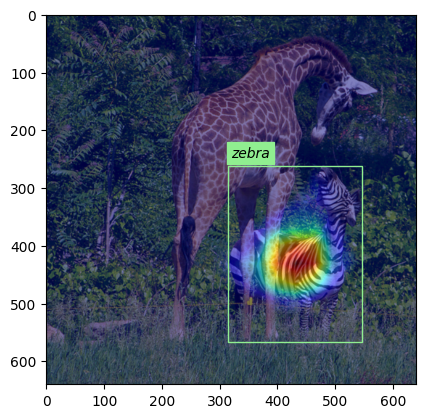

In [76]:
target_layer = [
    'head.cls_convs.0.0.act'
    'head.cls_convs.0.1.act',

    'head.cls_convs.1.0.act',
    'head.cls_convs.1.1.act',

    'head.cls_convs.2.0.act',
    'head.cls_convs.2.1.act',
  ]
model.zero_grad()
idx = 1
cam = GCAME(model, target_layer)
start = timeit.default_timer()
map = cam(img.to(device), box=box[0][idx], obj_idx=idx)
stop = timeit.default_timer()
print("Time: {}s".format(stop - start))

fig, ax = plt.subplots()
x1, y1, x2, y2 = box[0][idx][:4].detach().cpu().numpy()
cls = int(box[0][idx][6])
ax.text(x1+5, y1-16, coco[cls], style='italic', bbox={
          'facecolor': all_colors[cls], 'boxstyle': 'square', 'edgecolor': all_colors[cls]})
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
ax.add_patch(rect)
ax.imshow(img.squeeze().numpy().transpose(1, 2, 0).astype(np.uint8))
ax.imshow(map, cmap='jet', alpha=0.5)